# Working With Google Cloud BigQuery and Performing Data Analysis


## Questions To Solve 


- What is the trip duration distribution of Citibike trips?
- What is the most popular Citibike trip?
- Were there new bike stations introduced or removed at any point in time? What makes you think it were or weren't?


### Packges Used For the project
- Python 3.6
- Plotly
- Matplotlib
- GeoPandas
- Pandas
- descartes
- Shapely
- Plotly express 

## Rendering the notebook:
The images are interactive. You can zoom in or zoom out and you can get the information by hovering the mouse.

In [3]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Volumes/Seagate Expansion Drive/Udemy-Learn/Udemy-Learn-e892c5d9710a.json'

In [4]:
#Ignoring the warnings
import plotly.io as pio
pio.renderers.default = "svg"
import warnings
warnings.filterwarnings('ignore')
#connecting to the Cloud 
from google.cloud import bigquery
bigquery_client = bigquery.Client(project='udemy-learn-253112')

In [5]:
#Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')
#Connecting to the Big Query Client
bigquery_client = bigquery.Client()

In [6]:
#Imports 
import plotly.express as px
import plotly as py
import pandas as pd
import matplotlib.pyplot as plt
import descartes 
import geopandas as gpd
import plotly.graph_objects as go
from shapely.geometry import Point, Polygon
py.offline.init_notebook_mode(connected= True)
%matplotlib inline

In this jupyter notebook New Yok City bike data is explored. The data is available on google cloud. The data is analyzed before performing the assigned tasks.The dataset consists of two tables **Citi Bike Trips** and **Citi bike Stations**.

## Data Exploration

In [7]:
# Query To select all the columns of the citibike stations table
stations_columns = """SELECT *
FROM
 `bigquery-public-data.new_york.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS`
WHERE
 table_name="citibike_stations"
"""

In [8]:
#Execution of the query
station_job = bigquery_client.query(stations_columns)

In [9]:
#Converting the result into the dataframe
station_data = station_job.to_dataframe()

In [10]:
# Displaying the dataFrame of the station data 
fig = go.Figure(data=[go.Table(
    header=dict(values=['Column Name', 'Data Type','Description'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[station_data.column_name, # 1st column
                       station_data.data_type,   # 2nd Column
                      station_data.description], # Third column
               line_color='darkslategray',
               fill_color='lightcyan',
               align='center'))
])

fig.update_layout(width=800, height=1100)
fig.show()

The above diagram displays all the columns with its values and data types. 

In [11]:
# Query To select all the columns of the citibike trips table
trips_columns = """SELECT *
FROM
 `bigquery-public-data.new_york.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS`
WHERE
 table_name="citibike_trips"
"""

In [12]:
#Execution of the query
trip_job = bigquery_client.query(trips_columns)

In [13]:
#Converting the result into the dataframe
trip_data = trip_job.to_dataframe()


In [14]:
# Displaying the dataFrame of the trip data 
fig = go.Figure(data=[go.Table(
    header=dict(values=['Column Name', 'Data Type','Description'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='center'),
    cells=dict(values=[trip_data.column_name, # 1st column
                       trip_data.data_type,   # 2nd Column
                      trip_data.description], # Third column
               line_color='darkslategray',
               fill_color='lightcyan',
               align='center'))
])

fig.update_layout(width=800, height=550)
#fig.savefig('tabe1.png')
fig.show()


The above diagram displays all the columns with its values and data types for the citibike Trips table.

## Question 1:What is the trip duration distribution of Citibike trips?

The trip duration is in **seconds**. Below are the few cases that show the distribution in **hours and minutes**.

In [15]:
#SQL Query to find the distribution of the trips 
distribution_query = """SELECT tripduration , COUNT(*) AS trip_freq FROM (
    SELECT CASE
        WHEN (tripduration = 0) THEN 'No trip'
        WHEN (tripduration > 0 AND tripduration <= 300) THEN     'Trip between 0  to 5 minutes'
        WHEN (tripduration > 300 AND tripduration <= 600) THEN   'Trip between 5  to 10 minutes'
        WHEN (tripduration > 600 AND tripduration <= 900) THEN   'Trip between 10 to 15 minutes'
        WHEN (tripduration > 900 AND tripduration <= 1800) THEN  'Trip between 15 to 30 minutes'
        WHEN (tripduration > 1800 AND tripduration <= 3600) THEN 'Trip between 30mins to 1 hour'
        WHEN (tripduration > 3600 AND tripduration <= 7200) THEN 'Trip between 1 to 2 hours'
        
     
        ELSE 'Trip over 2 hours'
    END AS tripduration
FROM `bigquery-public-data.new_york.citibike_trips`
) Group by tripduration
order by trip_freq"""

In [16]:
#Execution of the query
distribution_job = bigquery_client.query(distribution_query)

In [17]:
#Converting the result into the dataframe
distribution_data = distribution_job.to_dataframe()

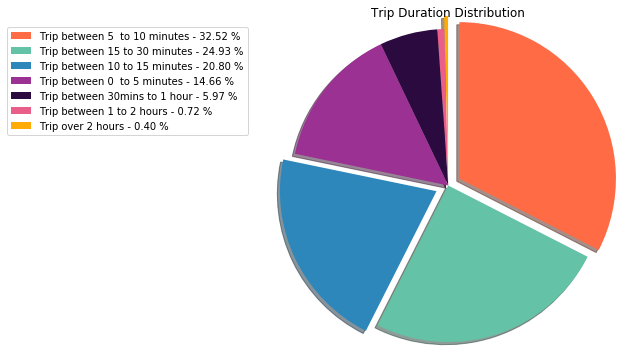

In [18]:
# PIE Chart
x =  distribution_data["tripduration"]
y = distribution_data["trip_freq"]



colors = ['#FFAB05','#EA5F89','#2B0B3F','#9B3192','#2D87BB','#64C2A6','#FF6B45']
percent = 100.*y/y.sum()
explode = (0.1, 0, 0,0,0.1,0,0.1)
plt.figure(figsize=(6,6))
patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2,explode= explode,shadow=True)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))
explode = (0, 0.1, 0, 0,0.1,0)
plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
           fontsize=10)
#plt.pie(startangle=90,shadow=True)
plt.title("Trip Duration Distribution")

plt.savefig('piechart.png', bbox_inches='tight')

From the Above pie chart it can be seen that people use the bicycle for short distances or short trips. People usually use the bicycle more frequently in the time intervals between **0 and 30 minutes**. As this duration represents the total of **78.25 percent** of the pie chart.



In [19]:
#Bar diagram for the trip distribution 
fig = px.bar(distribution_data, x='tripduration', y='trip_freq',
             hover_data=['tripduration', 'trip_freq'], color='trip_freq',
             labels={'pop':'Trip Distribution'}, height=600)

fig.show()
#py.offline.plot(fig, filename='name')
#fig.savefig('barchart.png', bbox_inches='tight')


From the bar chart it can be seen that the trips between **5 to 10** is more frequent as compared to the trips between **1 to 2 hours** and **Over 2 hours** that are very few. 

## What is the most popular Citibike trip?

In [20]:
#Query to fetch The popular trip
popular_trip_query= """SELECT
  start_station_name,
  end_station_name,
  
  
  COUNT (*) AS num_trips
FROM
  `bigquery-public-data.new_york.citibike_trips`
  

GROUP BY
  start_station_name,
  end_station_name
 
ORDER BY
  num_trips DESC
LIMIT
10


"""

In [21]:
#Query Execution
query_job = bigquery_client.query(popular_trip_query)

In [22]:
#COnversion to dataframe
popular_trips_df = query_job.to_dataframe()

In [23]:
#Using Plotly to draw a bar chart
fig = px.bar(popular_trips_df, x='start_station_name', y='num_trips',
             hover_data=['start_station_name', 'num_trips','end_station_name'], color='end_station_name',
             labels={'pop':'population of Canada'}, height=600)
fig.show()

The most popular trip is a round trip that starts from **Central Park S & 6 Ave**  and ends at the same location. It has **47215** number of trips.The second most popular starting point is **W 21 St & 6 Ave** with two different end destinations.

## Question 3: Were there new bike stations introduced or removed at any point in time? What makes you think it were or weren't

In [24]:
#Query to fetch name , longitude,latitude,renting,returning,installed status of the station
installed_removed_query= """SELECT
  name,
  latitude,
  longitude,
  is_installed,
  is_renting, is_returning,last_reported
  
FROM
  `bigquery-public-data.new_york.citibike_stations`  
  


"""

In [25]:
#Query Execution
installed_removed_job = bigquery_client.query(installed_removed_query)

In [26]:
#Converting to dataframe
installed_removed_df = installed_removed_job.to_dataframe()

In [27]:
installed_removed_df.head(20)

,name,latitude,longitude,is_installed,is_renting,is_returning,last_reported
0,Coming Soon: 5 St & 51 Ave,40.742374,-73.956600,False,False,False,1970-01-01 00:00:00+00:00
1,Coming Soon: Lenox Ave & W 117 St,40.802557,-73.949078,False,False,False,1970-01-01 00:00:00+00:00
2,Coming Soon: 31 St & 30 Ave,40.767006,-73.921406,False,False,False,1970-01-01 00:00:00+00:00
3,7 Ave & Park Pl,40.677615,-73.973243,True,False,False,1970-01-01 00:00:00+00:00
4,North Moore St & Greenwich St,40.720195,-74.010301,False,True,True,1970-01-01 00:00:00+00:00
5,E 58 St & Madison Ave,40.763026,-73.972095,True,False,False,1970-01-01 00:00:00+00:00
6,Coming Soon: Frederick Douglass Blvd & W 115 St,40.803865,-73.955931,False,False,False,1970-01-01 00:00:00+00:00
7,28 Ave & 43 St,40.764258,-73.911239,False,False,False,1970-01-01 00:00:00+00:00
8,31 Ave & Steinway St,40.761149,-73.917007,False,False,False,1970-01-01 00:00:00+00:00
9,E 2 St & Ave A,0.000000,0.000000,False,True,True,1970-01-01 00:00:00+00:00


Below are the data pionts showing the stations that are **not installed or maybe removed**  , not renting  and not returning.

In [28]:
no_station =installed_removed_df[(installed_removed_df['is_installed']==False) & 
(installed_removed_df['is_renting']==False) & 
(installed_removed_df['is_returning']==False)]

In [29]:
no_station.head(10)

,name,latitude,longitude,is_installed,is_renting,is_returning,last_reported
0,Coming Soon: 5 St & 51 Ave,40.742374,-73.956600,False,False,False,1970-01-01 00:00:00+00:00
1,Coming Soon: Lenox Ave & W 117 St,40.802557,-73.949078,False,False,False,1970-01-01 00:00:00+00:00
2,Coming Soon: 31 St & 30 Ave,40.767006,-73.921406,False,False,False,1970-01-01 00:00:00+00:00
6,Coming Soon: Frederick Douglass Blvd & W 115 St,40.803865,-73.955931,False,False,False,1970-01-01 00:00:00+00:00
7,28 Ave & 43 St,40.764258,-73.911239,False,False,False,1970-01-01 00:00:00+00:00
8,31 Ave & Steinway St,40.761149,-73.917007,False,False,False,1970-01-01 00:00:00+00:00


In [30]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Name', 'Installed','Returning','Renting'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='center'),
    cells=dict(values=[no_station.name, # 1st column
                       no_station.is_installed, #2nd column
                       no_station.is_returning,
                       no_station.is_renting,
                                            ], # Third column
               line_color='darkslategray',
               fill_color='lightcyan',
               align='center'))
])

fig.update_layout(width=900, height=550)
#fig.savefig('tabe1.png')
fig.show()



From the above table we can see that there are six stations that are  not working. From this we can interpret that these stations have been removed. But there is also one thing to notice if we closely examine the name column we can see that there are four stations that have written **Coming Soon** infront of their name. This **Coming Soon** word suggests that maybe in near future they will start working again.

Now i will select  the stations that are installed but they are not **accepting** or **returning** bikes

In [31]:
#Logical Condition to fetch the data.
station_installed=installed_removed_df[(installed_removed_df['is_installed']==True) & 
                                      ((installed_removed_df['is_renting']==False) &
(installed_removed_df['is_returning']==False))]

In [32]:
station_installed.head(30)

,name,latitude,longitude,is_installed,is_renting,is_returning,last_reported
3,7 Ave & Park Pl,40.677615,-73.973243,True,False,False,1970-01-01 00:00:00+00:00
5,E 58 St & Madison Ave,40.763026,-73.972095,True,False,False,1970-01-01 00:00:00+00:00
10,Montgomery St & Franklin Ave OLD,40.666165,-73.959348,True,False,False,1970-01-01 00:00:00+00:00
11,Norman Ave & Leonard St,40.725770,-73.950740,True,False,False,2018-01-05 16:43:26+00:00
17,Pacific St & Bedford Ave,40.677775,-73.952932,True,False,False,1970-01-01 00:00:00+00:00
23,Greenwich St & Hubert St,40.721319,-74.010065,True,False,False,1970-01-01 00:00:00+00:00
29,Fulton St & William St,40.709560,-74.006536,True,False,False,1970-01-01 00:00:00+00:00


In [33]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Name', 'Installed','Returning','Renting'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='center'),
    cells=dict(values=[station_installed.name, # 1st column
                       station_installed.is_installed, #2nd column
                       station_installed.is_returning,
                       station_installed.is_renting,
                                            ], # Third column
               line_color='darkslategray',
               fill_color='lightcyan',
               align='center'))
])

fig.update_layout(width=900, height=550)
#fig.savefig('tabe1.png')
fig.show()




From the above table we can see that seven stations that are installed but they are not **Renting or Returning**. From this we can interpret that these stations are closed. 

In [34]:

partially_working=installed_removed_df[(installed_removed_df['is_installed']==False) & 
                                       (installed_removed_df['is_renting']==True) & 
                                       (installed_removed_df['is_returning']==True)]

In [35]:
partially_working.head(20)

,name,latitude,longitude,is_installed,is_renting,is_returning,last_reported
4,North Moore St & Greenwich St,40.720195,-74.010301,False,True,True,1970-01-01 00:00:00+00:00
9,E 2 St & Ave A,0.000000,0.000000,False,True,True,1970-01-01 00:00:00+00:00


In [36]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Name', 'Installed','Returning','Renting'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='center'),
    cells=dict(values=[partially_working.name, # 1st column
                       partially_working.is_installed, #2nd column
                       partially_working.is_returning,
                       partially_working.is_renting,
                                            ], # Third column
               line_color='darkslategray',
               fill_color='lightcyan',
               align='center'))
])

fig.update_layout(width=950, height=300)
#fig.savefig('tabe1.png')
fig.show()



From the above table we can see that there are no stations **installed** but they are still **renting and returning** the bike. It can be a **wrong record** or the stations are under **construction** at that particular place.

## Map Overview of all the stations

In this step i will visualize all the stations on a map. For that we need the shape file. Lets load the file and start visualizing the stations on the map.

In [43]:
#Loading the shape File of the new york City
street_map = gpd.read_file("shape/geo_export_cffdb6d1-1f06-4f52-a76c-9647a7904bef.shp")

For visulising the data on the map i will use **geo pandas**.The next step is to convert the pandas dataframe into a geo-dataframe.In order to format our geometry appropriately, we will need to convert the **longitude and latitude** into **Points**

In [44]:
#Initializing the point system.
crs = {'init': 'epsg:4326'}

During the data exploration i found there are some errors in the longitude and latitude values. Now i will get rid off these values that can casue trouble during visualization

In [45]:
#Removing the bad values from the dataframe
installed_removed_df = installed_removed_df[installed_removed_df['latitude']!=0.0]

In [46]:
geometry = [Point (xy) for xy in zip(installed_removed_df["longitude" ],installed_removed_df["latitude"]) ]

In [47]:
#Converting the pandas dataframe to geo-data format
geo_df = gpd.GeoDataFrame(installed_removed_df,
                         crs = crs,
                        geometry= geometry)
geo_df.head()

,name,latitude,longitude,is_installed,is_renting,is_returning,last_reported,geometry
0,Coming Soon: 5 St & 51 Ave,40.742374,-73.956600,False,False,False,1970-01-01 00:00:00+00:00,POINT (-73.95660 40.74237)
1,Coming Soon: Lenox Ave & W 117 St,40.802557,-73.949078,False,False,False,1970-01-01 00:00:00+00:00,POINT (-73.94908 40.80256)
2,Coming Soon: 31 St & 30 Ave,40.767006,-73.921406,False,False,False,1970-01-01 00:00:00+00:00,POINT (-73.92141 40.76701)
3,7 Ave & Park Pl,40.677615,-73.973243,True,False,False,1970-01-01 00:00:00+00:00,POINT (-73.97324 40.67761)
4,North Moore St & Greenwich St,40.720195,-74.010301,False,True,True,1970-01-01 00:00:00+00:00,POINT (-74.01030 40.72020)


In [48]:
#Getting the index values of the stations that are fully closed.
geo_df[(geo_df['is_installed']==False) & (geo_df['is_renting']==False) & (geo_df['is_returning']==False)]

,name,latitude,longitude,is_installed,is_renting,is_returning,last_reported,geometry
0,Coming Soon: 5 St & 51 Ave,40.742374,-73.956600,False,False,False,1970-01-01 00:00:00+00:00,POINT (-73.95660 40.74237)
1,Coming Soon: Lenox Ave & W 117 St,40.802557,-73.949078,False,False,False,1970-01-01 00:00:00+00:00,POINT (-73.94908 40.80256)
2,Coming Soon: 31 St & 30 Ave,40.767006,-73.921406,False,False,False,1970-01-01 00:00:00+00:00,POINT (-73.92141 40.76701)
6,Coming Soon: Frederick Douglass Blvd & W 115 St,40.803865,-73.955931,False,False,False,1970-01-01 00:00:00+00:00,POINT (-73.95593 40.80387)
7,28 Ave & 43 St,40.764258,-73.911239,False,False,False,1970-01-01 00:00:00+00:00,POINT (-73.91124 40.76426)
8,31 Ave & Steinway St,40.761149,-73.917007,False,False,False,1970-01-01 00:00:00+00:00,POINT (-73.91701 40.76115)


In [49]:
#Making the list of all the index values
idx_full_closed= [0,1,2,6,7,8]

In [50]:
#marker size and color that will displayed on the data for the stations that are fully closed and fully working
MarkSize = [3 for i in range(installed_removed_df.shape[0])]
Label =  ['Fully functional' for i in range(installed_removed_df.shape[0])]
MarkColor = ['green' for i in range(installed_removed_df.shape[0])]
for idx, val in enumerate(idx_full_closed):
    MarkSize[val] = 20
    MarkColor[val] = 'red'
    Label[val]="Closed"

In [51]:
#Getting the index values of the stations that are installed but they are not working or out off business
geo_df[(geo_df['is_installed']==True) & ((geo_df['is_renting']==False) & (geo_df['is_returning']==False))]

,name,latitude,longitude,is_installed,is_renting,is_returning,last_reported,geometry
3,7 Ave & Park Pl,40.677615,-73.973243,True,False,False,1970-01-01 00:00:00+00:00,POINT (-73.97324 40.67761)
5,E 58 St & Madison Ave,40.763026,-73.972095,True,False,False,1970-01-01 00:00:00+00:00,POINT (-73.97210 40.76303)
10,Montgomery St & Franklin Ave OLD,40.666165,-73.959348,True,False,False,1970-01-01 00:00:00+00:00,POINT (-73.95935 40.66616)
11,Norman Ave & Leonard St,40.725770,-73.950740,True,False,False,2018-01-05 16:43:26+00:00,POINT (-73.95074 40.72577)
17,Pacific St & Bedford Ave,40.677775,-73.952932,True,False,False,1970-01-01 00:00:00+00:00,POINT (-73.95293 40.67777)
23,Greenwich St & Hubert St,40.721319,-74.010065,True,False,False,1970-01-01 00:00:00+00:00,POINT (-74.01006 40.72132)
29,Fulton St & William St,40.709560,-74.006536,True,False,False,1970-01-01 00:00:00+00:00,POINT (-74.00654 40.70956)


In [52]:
#Making the list of the index values
idx_no_business =[3,5,10,11,17,23,29]

In [53]:
#Marker Size and color for stations that are out of business
for idx, val in enumerate(idx_no_business):
    MarkSize[val] = 20
    MarkColor[val] = 'blue'
    Label [val]="Installed but not working"

In [54]:
#Getting the index values of the stations that are not installed but they are accepting and returning
#This observation can be wrong in the record. But just for the sake of visulaization.
geo_df[(geo_df['is_installed']==False) & (geo_df['is_renting']==True) & (geo_df['is_returning']==True)]

,name,latitude,longitude,is_installed,is_renting,is_returning,last_reported,geometry
4,North Moore St & Greenwich St,40.720195,-74.010301,False,True,True,1970-01-01 00:00:00+00:00,POINT (-74.01030 40.72020)


We can see that we only got **one** value. But with the same operation in the section above that  i got **two** results. The second station got the wrong values for the **longitude and latitude** so we **removed** that point from our dataset. That's why we only get one value here

In [55]:
#Making List
idx_wrong_observation=[4]
#Marker Size and color for stations that are not installed
for idx, val in enumerate(idx_wrong_observation):
    MarkSize[val] = 20
    MarkColor[val] = 'black'
    Label[val]="Not installed But working"

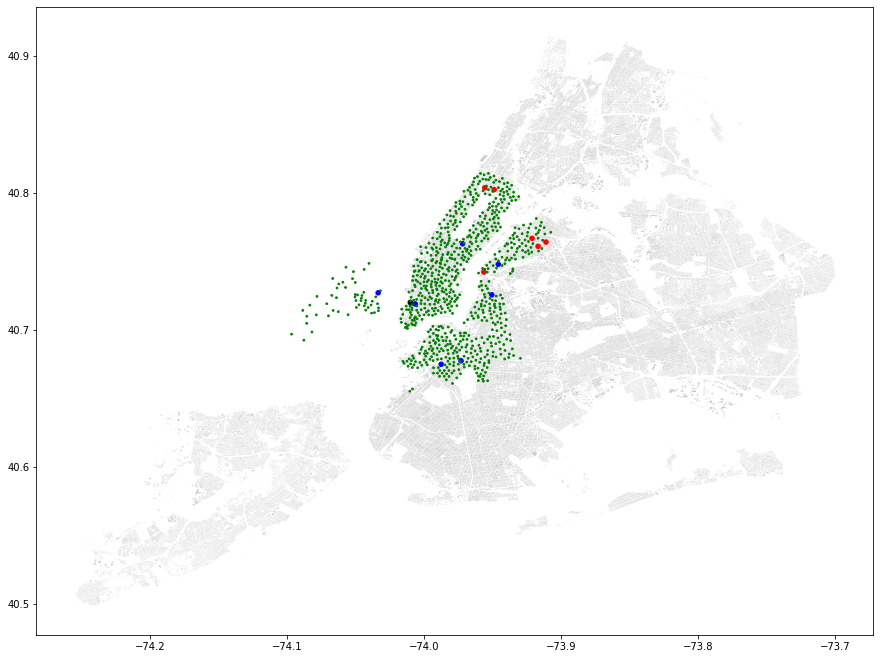

In [56]:
#Now i will plot these points on the shape map
fig,ax = plt.subplots(figsize = (15, 15))
street_map.plot(ax =ax ,alpha = 0.4, color = "grey")

geo_df.plot(ax=ax, markersize = MarkSize, c=MarkColor)
#plt.legend(prop={'size':10})

The above diagram shows the stations on the map. 
- The **green** color dot represents the stations that are fully functional. 
- The **red** color dots represents the stations that have been removed.
- The **Blue** color dots represents the stations that are still installed but they are not working or out of order.
- The **black color** dots represents that places where there is no station installed but the renting and returning     status is true. This observation can be an error